# Binary Classification on the SpO2 data

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl

## Dataset class

In [2]:
project_path = Path.cwd().parent
input_path = project_path / 'data' / 'SpO2' / 'SpO2_input.csv'
output_path = project_path / 'data' / 'SpO2' / 'SpO2_output.csv'

In [3]:
split_ratio = 0.8

In [4]:
class Hypnogram(Dataset):

    def __init__(self, input_path: Path, output_path: Path, train=True, scale=False):
        x = np.loadtxt(input_path, dtype=int, delimiter=',')
        y = np.loadtxt(output_path, dtype=int, delimiter=',')
        if scale:
            x = (x - np.min(x)) / (np.max(x) - np.min(x))

        split_index = int(x.shape[0] * split_ratio)
        if train:
            self.x = x[:split_index, :]
            self.y = y[:split_index]
        else:
            self.x = x[split_index:, :]
            self.y = y[split_index:]
        assert self.x.shape[0] == self.y.shape[0]
        self.x = torch.tensor(self.x, dtype=torch.float)
        self.y = torch.tensor(self.y, dtype=torch.float)
        self.y = torch.unsqueeze(self.y, dim=1)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def print_info(self):
        print(f"{self.x.shape = }")
        print(f"{self.y.shape = }")
        print(f"{torch.max(self.x) = }")
        print(f"{torch.min(self.x) = }")

### Integer dataset (no scaling)

In [5]:
train_dataset_int = Hypnogram(input_path=input_path, 
                          output_path=output_path, 
                          train=True,
                          scale=False)
test_dataset_int = Hypnogram(input_path=input_path, 
                             output_path=output_path, 
                             train=False,
                             scale=False)

train_dataset_int.print_info()
test_dataset_int.print_info()

self.x.shape = torch.Size([36865, 300])
self.y.shape = torch.Size([36865, 1])
torch.max(self.x) = tensor(31.)
torch.min(self.x) = tensor(0.)
self.x.shape = torch.Size([9217, 300])
self.y.shape = torch.Size([9217, 1])
torch.max(self.x) = tensor(31.)
torch.min(self.x) = tensor(0.)


In [6]:
batch_size = 4

train_loader_int = DataLoader(train_dataset_int, batch_size=batch_size)
test_loader_int = DataLoader(test_dataset_int, batch_size=batch_size)

### Float dataset (min-max scaling)

In [7]:
train_dataset_scaled = Hypnogram(input_path=input_path, 
                                 output_path=output_path,
                                 train=True, 
                                 scale=True)
train_dataset_scaled.print_info()

test_dataset_scaled = Hypnogram(input_path=input_path, 
                                output_path=output_path,
                                train=False, 
                                scale=True)
test_dataset_scaled.print_info()

self.x.shape = torch.Size([36865, 300])
self.y.shape = torch.Size([36865, 1])
torch.max(self.x) = tensor(1.)
torch.min(self.x) = tensor(0.)
self.x.shape = torch.Size([9217, 300])
self.y.shape = torch.Size([9217, 1])
torch.max(self.x) = tensor(1.)
torch.min(self.x) = tensor(0.)


In [8]:
train_loader_scaled = DataLoader(train_dataset_scaled, batch_size=batch_size)
test_loader_scaled = DataLoader(test_dataset_scaled, batch_size=batch_size)

## The train function and hyper params

In [9]:
epoch = 1000 
lr = 0.001

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [10]:
def train(model, train_loader, test_loader, device = torch.device('cpu'), save_weight_path = None):
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    train_accuracies = []
    test_accuracies = []
    best_test_acc = 0

    for e in range(epoch):
        print(f"--------- epoch: {e+1} ---------")
        # training
        train_loss = 0.0
        corrects = 0
        total_examples = 0
        for i, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()  # zero the gradients
            # prepare data
            x = x.to(device)
            y = y.to(device).to(torch.float32)
            # the forward pass
            y_pred = model(x)
            y_pred = y_pred.reshape(y.shape)
            # the backward pass
            loss = criterion(y_pred, y)  # calculate the loss
            loss.backward()  # get the gradients
            optimizer.step()  # update the params based on the gradients
            # collect training results
            train_loss += loss.item()
            corrects += torch.sum((y_pred.round() == y))
            total_examples += len(y)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(corrects / total_examples)
        print(f"num_corrects / total_examples = {corrects.item()} / {total_examples}")
        print(f"training loss = {train_losses[-1]:.4f}")
        print(f"training accuracy = {train_accuracies[-1]:.4f}")
        # print(total_examples)

        # testing
        test_corrects = 0
        test_total_examples = 0
        with torch.no_grad():
            for i, (x, y) in enumerate(test_loader):
                # prepare data
                x = x.to(device)
                y = y.to(device).to(torch.float32)
                # the forward pass
                y_pred = model(x)
                y_pred = y_pred.reshape(y.shape)
                # collect testing results
                test_corrects += torch.sum((y_pred.round() == y))
                test_total_examples += len(y)

        test_acc = test_corrects.item() / test_total_examples
        test_accuracies.append(test_acc)
        print(f"num_test_corrects / test_total_examples = {test_corrects.item()} / {test_total_examples}")
        print(f"testing accuracy = {test_accuracies[-1]:.4f}")
        if test_acc > best_test_acc:
            print(f"found best test accuracy at epoch {e+1}")
            best_test_acc = test_acc
            if save_weight_path is not None:
                # save the model
                torch.save({
                    'epoch': e+1,
                    'model_state_dict': model.state_dict(),
                    'test_acc': test_acc,
                }, save_weight_path)
                print(f"save the model checkpoint to {save_weight_path}")

    return train_losses, train_accuracies, test_accuracies

## 1 FC Layer Model

In [5]:
class TorchLinearModel(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(TorchLinearModel, self).__init__()
        self.linear = torch.nn.Linear(input_size, output_size)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        y_pred = self.linear(x)
        y_pred = self.sigmoid(y_pred)
        return y_pred

### Train on Integer Data (No Scaling)

In [9]:
# training the simple nn on CPU is much faster
lr_model = TorchLinearModel(300, 1)
lr_model.to(device)
lr_model

TorchLinearModel(
  (linear): Linear(in_features=300, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

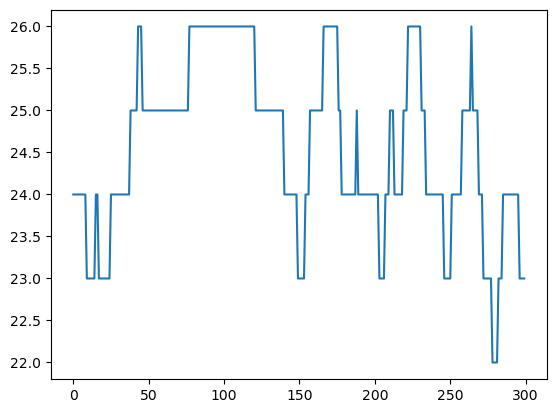

In [12]:
plt.plot(train_dataset.x[0])

In [ ]:
train_losses, train_accuracies, test_accuracies = train(lr_model, train_loader, test_loader)

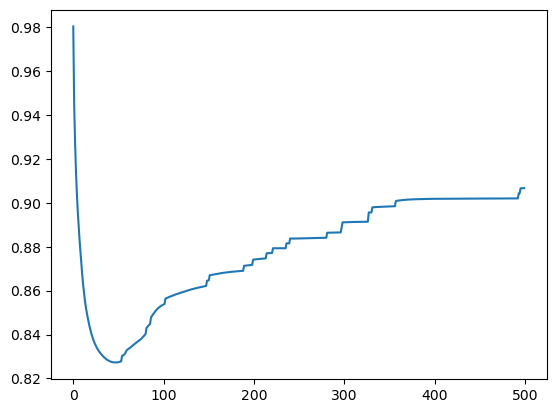

In [14]:
plt.plot(train_losses)

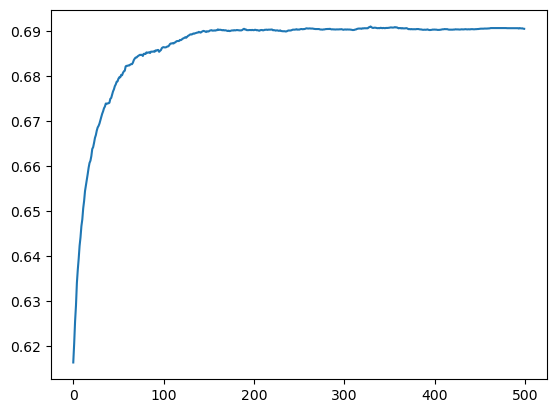

In [15]:
if device.type == 'cuda':
    train_accuracies = [acc.cpu() for acc in train_accuracies]
plt.plot(train_accuracies)

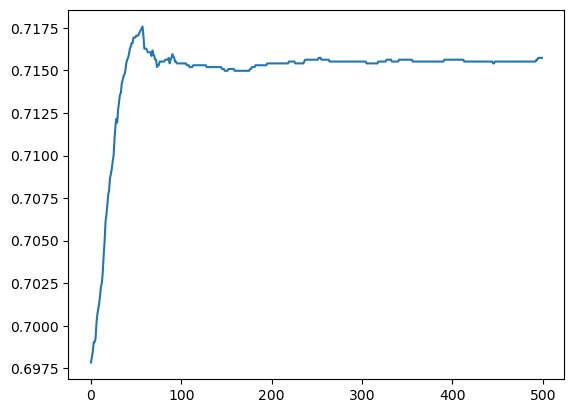

In [16]:
plt.plot(test_accuracies)

In [17]:
print(f"max train accuracy = {max(train_accuracies)}")
print(f"max test accuracy = {max(test_accuracies)}")

max train accuracy = 0.6909534931182861
max test accuracy = 0.7175870673755018


In [18]:
for param in lr_model.parameters():
    print(param)

Parameter containing:
tensor([[-0.0475,  0.1035, -0.0447, -0.0250, -0.1009,  0.1327, -0.0243,  0.0446,
         -0.0705,  0.0117,  0.0269, -0.0262,  0.0708, -0.1628,  0.0670, -0.0204,
          0.0022,  0.1177, -0.0419,  0.0290, -0.1351,  0.0856,  0.0096, -0.0676,
         -0.0191,  0.0309, -0.0240,  0.0377, -0.0050,  0.0314, -0.0844,  0.0493,
          0.0681, -0.0734, -0.0164, -0.0241,  0.0482, -0.0055, -0.0927,  0.0939,
          0.0143, -0.0523,  0.0284, -0.0237, -0.0709,  0.0867, -0.0470,  0.0380,
         -0.1166,  0.0613,  0.0170, -0.0462,  0.0557, -0.0159,  0.0035, -0.0027,
         -0.0035, -0.0178, -0.0328,  0.0420,  0.0055, -0.0318, -0.0012,  0.0088,
         -0.0286,  0.1226, -0.0468, -0.1034,  0.0386,  0.0867, -0.0821, -0.0181,
         -0.0529,  0.0987, -0.1463,  0.0284, -0.0308,  0.1270, -0.1194,  0.0476,
         -0.0543,  0.0328,  0.0013,  0.0659, -0.0322, -0.0188, -0.0099, -0.0390,
         -0.0092,  0.0735, -0.0243, -0.0333, -0.0325,  0.0263,  0.0452, -0.0362,
      

### Train on Float Data (Min-max Scaling)

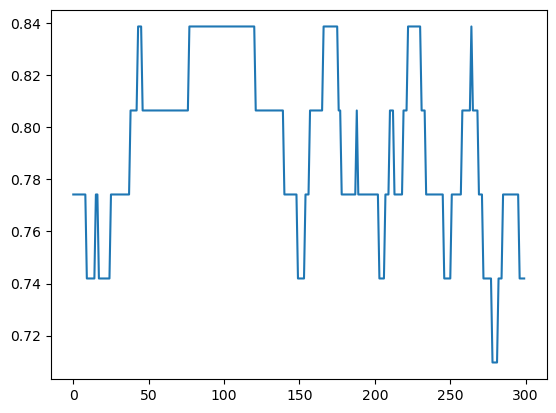

In [15]:
plt.plot(train_dataset_scaled.x[0])

In [17]:
device = torch.device('cpu')
lc_model = TorchLinearModel(300, 1)
lc_model.to(device)
lc_model

TorchLinearModel(
  (linear): Linear(in_features=300, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [18]:
save_weight_path = project_path / 'weights' / 'hypnogram' / 'lc_model_scaled_hypnogram_1000epoch.pt'
train_losses_2, train_accuracies_2, test_accuracies_2 = train(lc_model, 
                                                              train_loader_scaled, 
                                                              test_loader_scaled,
                                                              save_weight_path)

--------- epoch: 1 ---------
num_corrects / total_examples = 25736 / 36865
training loss = 0.5986
training accuracy = 0.6981
num_test_corrects / test_total_examples = 6444 / 9217
testing accuracy = 0.6991
found best test accuracy at epoch 1
save the model checkpoint to /home/dk/Desktop/projects/PocketHHE/weights/hypnogram/lc_model_scaled_hypnogram_1000epoch.pt
--------- epoch: 2 ---------
num_corrects / total_examples = 26079 / 36865
training loss = 0.5848
training accuracy = 0.7074
num_test_corrects / test_total_examples = 6490 / 9217
testing accuracy = 0.7041
found best test accuracy at epoch 2
save the model checkpoint to /home/dk/Desktop/projects/PocketHHE/weights/hypnogram/lc_model_scaled_hypnogram_1000epoch.pt
--------- epoch: 3 ---------
num_corrects / total_examples = 26325 / 36865
training loss = 0.5744
training accuracy = 0.7141
num_test_corrects / test_total_examples = 6541 / 9217
testing accuracy = 0.7097
found best test accuracy at epoch 3
save the model checkpoint to /hom

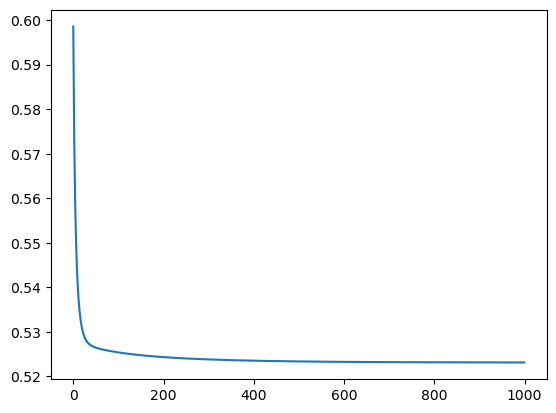

In [19]:
plt.plot(train_losses_2)

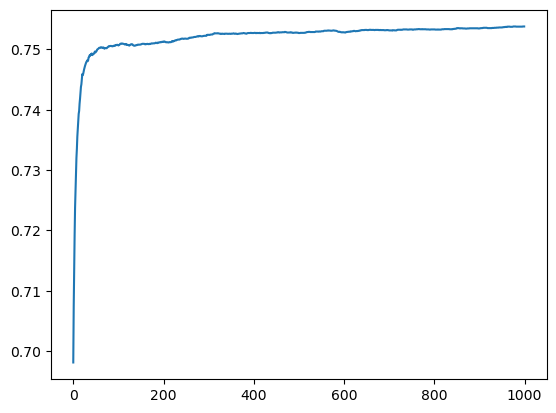

In [20]:
plt.plot(train_accuracies_2)

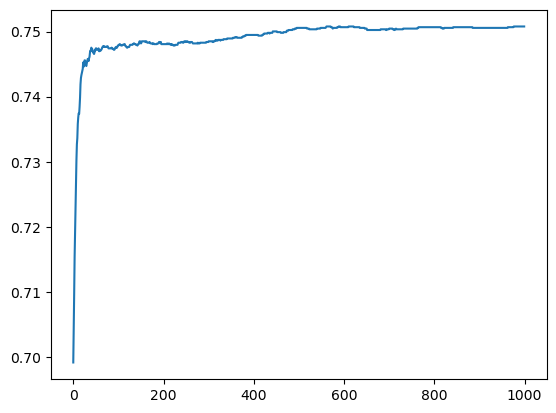

In [21]:
plt.plot(test_accuracies_2)

In [22]:
print(f"max train accuracy = {max(train_accuracies_2)}")
print(f"max test accuracy = {max(test_accuracies_2)}")

max train accuracy = 0.7538044452667236
max test accuracy = 0.7507865899967452


## Square Neural Network (2 FC Layers)

In [20]:
class SquareModel(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(SquareModel, self).__init__()
        self.linear_1 = torch.nn.Linear(input_size, 128, bias=False)
        self.linear_2 = torch.nn.Linear(128, output_size, bias=False)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        x = self.linear_1(x)
        x = torch.square(x)
        x = self.linear_2(x)
        y_pred = self.sigmoid(x)
        return y_pred

In [21]:
device = torch.device('cpu')
# device = torch.device('cuda')
square_model = SquareModel(300, 1)
square_model.to(device)
square_model

SquareModel(
  (linear_1): Linear(in_features=300, out_features=128, bias=False)
  (linear_2): Linear(in_features=128, out_features=1, bias=False)
  (sigmoid): Sigmoid()
)

In [22]:
# save_weight_path = project_path / 'weights' / 'hypnogram' / 'square_model_scaled_hypnogram_1000epoch.pt'
train_losses, train_accs, test_accs = train(square_model, 
                                            train_loader_scaled, 
                                            test_loader_scaled,
                                            device=device,
                                            save_weight_path=None)

--------- epoch: 1 ---------
num_corrects / total_examples = 25670 / 36865
training loss = 0.5866
training accuracy = 0.6963
num_test_corrects / test_total_examples = 6526 / 9217
testing accuracy = 0.7080
found best test accuracy at epoch 1
--------- epoch: 2 ---------
num_corrects / total_examples = 27267 / 36865
training loss = 0.5450
training accuracy = 0.7396
num_test_corrects / test_total_examples = 6939 / 9217
testing accuracy = 0.7528
found best test accuracy at epoch 2
--------- epoch: 3 ---------
num_corrects / total_examples = 28141 / 36865
training loss = 0.5226
training accuracy = 0.7634
num_test_corrects / test_total_examples = 6944 / 9217
testing accuracy = 0.7534
found best test accuracy at epoch 3
--------- epoch: 4 ---------
num_corrects / total_examples = 28427 / 36865
training loss = 0.5199
training accuracy = 0.7711
num_test_corrects / test_total_examples = 6989 / 9217
testing accuracy = 0.7583
found best test accuracy at epoch 4
--------- epoch: 5 ---------
num_cor

KeyboardInterrupt: 

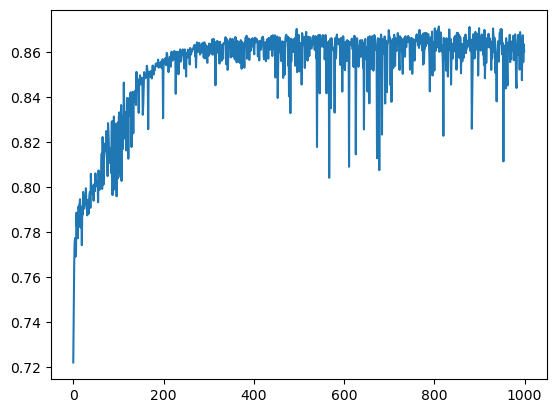

In [21]:
plt.plot(test_accuracies_2)

In [22]:
print(f"max train accuracy = {max(train_accuracies_2)}")
print(f"max test accuracy = {max(test_accuracies_2)}")

max train accuracy = 0.8985216617584229
max test accuracy = 0.8713247260496908


## Square Root Neural Network (2 FC layers)

In [22]:
class SquareRootModel(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(SquareRootModel, self).__init__()
        self.linear_1 = torch.nn.Linear(input_size, 128)
        self.linear_2 = torch.nn.Linear(128, output_size)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        x = self.linear_1(x)
        x = 0.563059 + 0.5*x + 0.078047*torch.square(x)
        x = self.linear_2(x)
        y_pred = self.sigmoid(x)
        return y_pred

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sqrt_model = SquareRootModel(300, 1)
sqrt_model.to(device)
sqrt_model

SquareRootModel(
  (linear_1): Linear(in_features=300, out_features=128, bias=True)
  (linear_2): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [24]:
# save_weight_path = project_path / 'weights' / 'hypnogram' / 'lc_model_scaled_hypnogram_1000epoch.pt'
train_losses, train_accs, test_accs = train(sqrt_model, 
                                            train_loader_scaled, 
                                            test_loader_scaled,
                                            device=device,
                                            save_weight_path=None)

--------- epoch: 1 ---------
num_corrects / total_examples = 27219 / 36865
training loss = 0.5310
training accuracy = 0.7383
num_test_corrects / test_total_examples = 6871 / 9217
testing accuracy = 0.7455
found best test accuracy at epoch 1
--------- epoch: 2 ---------
num_corrects / total_examples = 27589 / 36865
training loss = 0.5138
training accuracy = 0.7484
num_test_corrects / test_total_examples = 6896 / 9217
testing accuracy = 0.7482
found best test accuracy at epoch 2
--------- epoch: 3 ---------
num_corrects / total_examples = 27656 / 36865
training loss = 0.5092
training accuracy = 0.7502
num_test_corrects / test_total_examples = 6918 / 9217
testing accuracy = 0.7506
found best test accuracy at epoch 3
--------- epoch: 4 ---------
num_corrects / total_examples = 27705 / 36865
training loss = 0.5060
training accuracy = 0.7515
num_test_corrects / test_total_examples = 6928 / 9217
testing accuracy = 0.7517
found best test accuracy at epoch 4
--------- epoch: 5 ---------
num_cor

KeyboardInterrupt: 

## Training with Pytorch Lightning - Experimental

In [9]:
class LinearModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(300, 1)
        self.sigmoid = torch.nn.Sigmoid()
        self.criterion = torch.nn.BCELoss()
        self.training_step_outputs = []
        self.val_step_outputs = []

    def training_step(self, train_batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = train_batch
        y_hat = self.sigmoid(self.linear(x))
        loss = self.criterion(y_hat, y)
        self.training_step_outputs.append(y_hat.round() == y)
        self.log("train_loss", loss)
        return loss

    def on_train_epoch_end(self):
        train_preds = torch.cat(self.training_step_outputs, dim=0)
        train_acc = torch.sum(train_preds) / train_preds.shape[0]
        self.log("train_acc", train_acc)
        print(f"train acc = {train_acc}")
        self.training_step_outputs.clear()
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_hat = self.sigmoid(self.linear(x))
        self.val_step_outputs.append(y_hat.round() == y)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss)
    
    def on_validation_epoch_end(self):
        val_preds = torch.cat(self.val_step_outputs, dim=0)
        val_acc = torch.sum(val_preds) / val_preds.shape[0]
        self.log("val_acc", val_acc)
        print(f"val acc = {val_acc}")
        self.val_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

lr_model = LinearModel()

In [10]:
# test run on 100 data batches and 1 epoch
trainer = pl.Trainer(limit_train_batches=100, max_epochs=1)
trainer.fit(model=lr_model, train_dataloaders=train_loader, val_dataloaders=test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | linear    | Linear  | 301   
1 | sigmoid   | Sigmoid | 0     
2 | criterion | BCELoss | 0     
--------------------------------------
301       Trainable params
0         Non-trainable params
301       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 109.46it/s]val acc = 0.75
                                                                            

/home/dk/miniconda3/envs/pockethhe/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 100/100 [00:06<00:00, 14.66it/s, v_num=2] train acc = 0.6074999570846558


`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 100/100 [00:06<00:00, 14.64it/s, v_num=2]


In [12]:
num_epochs = 5
trainer = pl.Trainer(max_epochs=num_epochs)
trainer.fit(model=lr_model, train_dataloaders=train_loader, val_dataloaders=test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name      | Type    | Params
--------------------------------------
0 | linear    | Linear  | 301   
1 | sigmoid   | Sigmoid | 0     
2 | criterion | BCELoss | 0     
--------------------------------------
301       Trainable params
0         Non-trainable params
301       Total params
0.001     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 9217/9217 [00:41<00:00, 220.83it/s, v_num=4]train acc = 0.6374338865280151


`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 9217/9217 [00:41<00:00, 220.68it/s, v_num=4]
